# Часть 1

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats

plt.style.use('ggplot')

## Этап 1

In [2]:
uplift_df = pd.read_csv('uplift_fp_data.csv')
uplift_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


In [3]:
uplift_df.isna().sum()

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

## Этап 2

### EDA


/tmp/ipykernel_8599/2455593760.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(uplift_df['treatment'].value_counts(), palette='pastel')


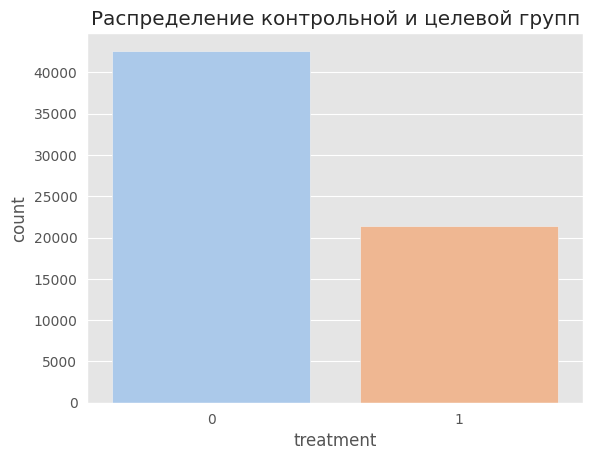

In [13]:
sns.barplot(uplift_df['treatment'].value_counts(), palette='pastel')
plt.title('Распределение контрольной и целевой групп')
plt.show()

In [16]:
print('Распределение целевой переменной в целевой группе:')
print(uplift_df[uplift_df['treatment'] == 1]['target'].value_counts())
print('\n\nРаспределение целевой переменной в контрольной группе:')
print(uplift_df[uplift_df['treatment'] == 0]['target'].value_counts())

Распределение целевой переменной в целевой группе:
target
0    18149
1     3238
Name: count, dtype: int64


Распределение целевой переменной в контрольной группе:
target
0    36457
1     6156
Name: count, dtype: int64


**Выводы:**

* Количество наблюдений целевой группы в два раза меньше, чем в контрольной
* И в контрольной, и в целевой группах target=1 занимает примерно одну шестую часть наблюдений

# Этап 2

### Проверка на статистическую значимость

Обоснуйте выбор статистического теста в данной ячейке

In [21]:
uplift_df[uplift_df['treatment'] == 1]['target'].mean()

0.151400383410483

In [25]:
# проверим распределения целевой и контрольной групп на нормальность

p_t = uplift_df[uplift_df['treatment'] == 1]['target'].mean()
p_c = uplift_df[uplift_df['treatment'] == 0]['target'].mean()

sigma_t = np.sqrt(p_t * (1 - p_t) / uplift_df[uplift_df['treatment'] == 1]['target'].count())
sigma_c = np.sqrt(p_c * (1 - p_c) / uplift_df[uplift_df['treatment'] == 0]['target'].count())

p_value_t = 1 - stats.norm.cdf(p_t / sigma_t)
p_value_c = 1 - stats.norm.cdf(p_c / sigma_c)

print(f"Target P-Value={p_value_t}") 
print(f"Control P-Value={p_value_c}") 

Target P-Value=0.0
Control P-Value=0.0


Целевые переменные обеих групп распределены нормально, след-но, можем применить тест Стьюдента

In [ ]:

mu = p_t - p_c
sigma = np.sqrt(p_t * (1 - p_t) / uplift_df[uplift_df['treatment'] == 1]['target'].count() + p_c * (1 - p_c) / uplift_df[uplift_df['treatment'] == 0]['target'].count())

p_value = 1 - stats.norm.cdf(mu / sigma)

print(f"P-Value={p_value}") 

P-Value=0.010051278040431266


P-Value **меньше порогового значения 0.05**, следовательно, коммуникация дала статистически значимый положительный эффект

## Построение корреляций

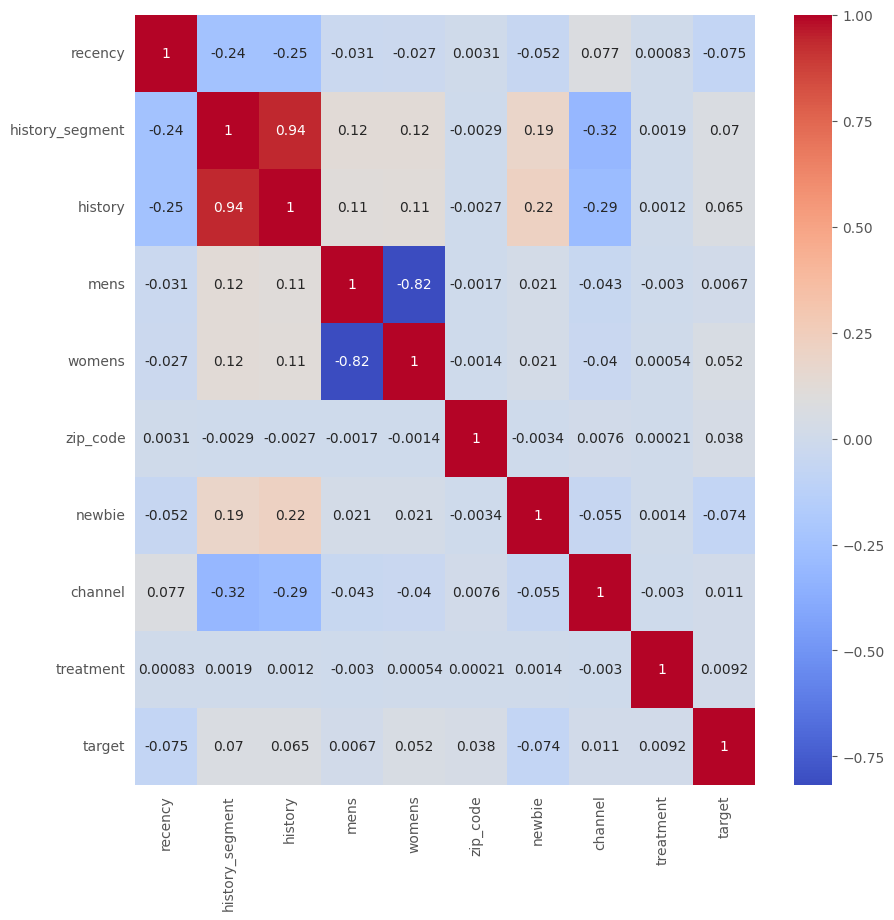

In [32]:
f, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(uplift_df.corr(), annot=True, cmap='coolwarm')
plt.show()

Наибольшая прямая связь с таргетом прослеживается у следующих признаков (в порядке убывания значимости):
* history_segment
* history
* womens
* zip_code

Наибольшая обратная связь с таргетом прослеживается у следующих признаков (в порядке убывания значимости):
* recency
* newbie

Наибольшая прямая связь среди признаков наблюдается между history_segment и history, корреляция 0.94. Данные переменные имеют также сильную связь с признаками:
* newbie (0.19 и 0.22)
* channel (-0.32, -0.29)
* womens (0.12, 0.11)
* recency (-0.24, -0.25)

## Этап 3

Обоснуйте выбор конкретной uplift модели в данной ячейке

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [34]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(uplift_df, stratify=uplift_df[['treatment', 'target']], test_size=0.2, random_state=42)

In [40]:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания 
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['treatment'] == 0)
    N_t = sum(ranked['treatment'] == 1)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target == 1,'n_c1'] = 1
    ranked.loc[ranked.target == 1,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum() 

### Обучение выбранного бейзлайна

In [36]:
feature_cols = ['history_segment', 'history', 'womens', 'zip_code', 'recency', 'newbie', 'channel']
treatment_col = 'treatment'
target_col = 'target'

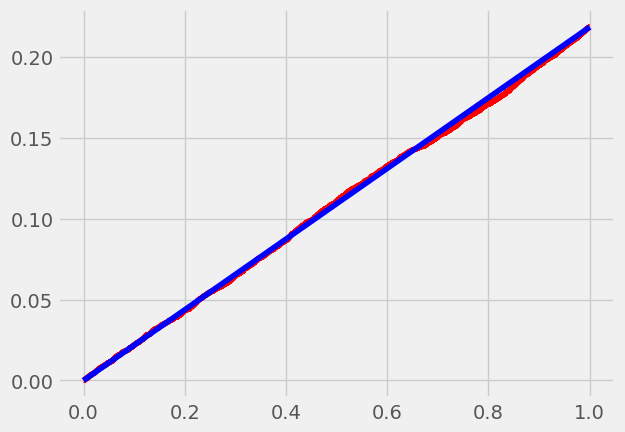

-8.716850000000003

In [41]:
from causalml.inference.meta import BaseSClassifier
from causalml.metrics import qini_score
from catboost import CatBoostClassifier

s_learner = BaseSClassifier(learner=CatBoostClassifier(random_state=42, verbose=0))

s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

### Расчет метрик для выбранного бейзлайна на тестовой выборке

# Обучение 2 моделей 

### Обучение модели 1

### Получение метрик по модели 1

### Обучение модели 2

### Получение метрик по модели 2

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

#### Генерация признаков (опционально)

### Подбор гиперпараметров

In [ ]:
from optuna import create_study
from sklift.metrics import uplift_at_k

def objective(trial):
    # Дополните код для подбора гиперпараметров

    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [138]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [126]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)